## Instructions

You are to submit the following files, in the naming convention below:
- The Jupyter Notebook as `G_XX_S_X_PA4.ipynb`
- The Python File as `G_XX_S_X_PA4.py`
- Your final models as `G_XX_S_X_FFN/CNN.pth`

Please add all of these in a single zip (not winrar) file. Rename it to `G_XX_S_X_PA4.zip`

## Section 1: Introduction to PyTorch [10 Marks]

### Task 0: Installing PyTorch
To install PyTorch on your local machine, please go through the official [guide](https://pytorch.org/get-started/locally/). Alternatively, you can use Google Colab for the assignment which has PyTorch installed and configured out of the box. Also, go through the official PyTorch [tutorial](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)

In [165]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm

### Task 1: Understanding Tensor Manipulation

Implement the following functions using PyTorch. You are not allowed to change any function definitions. You may find the following PyTorch utilities helpful. You may read up more in the [documentation](https://pytorch.org/docs/stable/torch.html).

```python
torch.tensor([...])         # Create tensor from list or nested list
torch.arange(start, end)    # Range of values (1D)
torch.ones(size)            # Tensor filled with ones
torch.zeros(size)           # Tensor filled with zeros
torch.rand(size)            # Uniformly random values in [0, 1)
torch.randn(size)           # Normally distributed values

tensor + other              # Element-wise addition
tensor - other              # Element-wise subtraction
tensor * other              # Element-wise multiplication
tensor / other              # Element-wise division
tensor @ other              # Matrix multiplication (preferred over matmul)

tensor.shape                # Get the shape (tuple of dimensions)
tensor.dtype                # Data type (e.g., float32, int64)
tensor.device               # Shows whether on CPU or GPU

tensor.reshape(new_shape)     # Change shape (returns a copy)
tensor.view(new_shape)        # Alternative to reshape (may share memory)
tensor.T                      # Transpose 2D tensor
tensor.transpose(dim0, dim1)  # Swap two dimensions

```
---

$$
f_1 = a + \mathbf{1}
$$

Where $a$ can be a tensor of any shape, and $1$ dynamically takes the shape of $a$.

In [166]:
### Function Definition.
def f1(a):
    shape = a.shape
    f = a + torch.ones(shape)
    return f

In [167]:
### Test your function.
a = torch.rand(1,2,3)
print(f"Before passing the tensor through function: {a}")
f = f1(a)
print(f"After passing the tensor through function: {f}")

Before passing the tensor through function: tensor([[[0.6942, 0.8548, 0.5588],
         [0.3574, 0.1914, 0.8832]]])
After passing the tensor through function: tensor([[[1.6942, 1.8548, 1.5588],
         [1.3574, 1.1914, 1.8832]]])


---


$$
f_2 = (A \cdot v)^T \odot v^T
$$

- $A$ = $\begin{pmatrix}
1 & 2 & 3 \\
4 & 5 & 6 \\
7 & 8 & 9
\end{pmatrix}$
- $v$ can be any vector of appropriate shape, your function should explicitly check this and return 0 if v is not of appropriate shape.
- $\odot$ represents element wise multiplication


In [168]:
### Function Definition.
def f2(v):
    a = torch.tensor([[1,2,3],[4,5,6],[7,8,9]],dtype=torch.float32)

    if v.shape not in [(3,), (3, 1)]:
        return torch.tensor(0)

    # Ensure v is a column vector (3x1) for matrix multiplication
    if v.dim() == 1 :
      v = v.reshape(-1,1)
    else:
      pass

    Av = torch.matmul(a, v)


    Av_T = Av.T  # Shape: [1, 3]
    v_T = v.T    # Shape: [1, 3]


    f2 = Av_T * v_T  # Shape: [1, 3]

    return f2

In [169]:
### Test your function.
v = torch.rand(3)  # Shape (3,)
f = f2(v)
print("f2:\n", f)

f2:
 tensor([[2.6104, 2.1180, 6.7117]])


### Task 2: Understanding Devices in PyTorch (CPU, CUDA, MPS)

PyTorch can run tensor computations on different devices: `cpu` (default), `cuda` (for NVIDIA GPUs), and `mps` (for Apple Silicon GPUs). These devices speed up computation, especially for large tensors or deep learning models.

To use a device, you must **explicitly send tensors to it** using `.to(device)` or create them directly on the device. If two tensors are involved in an operation, **they must be on the same device**. Otherwise, PyTorch will raise a runtime error.

Below is an example setup — uncomment the line matching your hardware.


In [170]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # For NVIDIA GPU
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")  # For Apple Silicon

print(device)

cuda


Now implement the following function:

$$
f_3 = r^T \cdot X
$$

Where:

- $r \in \mathbb{R}^{4 \times 1}$ is a random tensor generated by `torch.rand`
- $X \in \mathbb{R}^{4 \times 5}$ is a tensor with values from 1 to 20 (inclusive), reshaped to shape $(4, 5)$
- Make sure the function explicitly sends r and X to whatever device is passed. The returned tensor should also be on the same device.

In [171]:
### Function Definition.
def f3(device):
    r = torch.rand((4,1), device=device,dtype=torch.float32)
    x = torch.tensor([[1,2,3,4,5],[6,7,8,9,10],[11,12,13,14,15],[16,17,18,19,20]], device=device, dtype=torch.float32)
    x.reshape(4,5)
    r_t = r.T
    result = r_t @ x
    return result

In [172]:
### Test your function.

cpu_result = f3(device)
print("Result:", cpu_result)


Result: tensor([[18.8357, 21.1184, 23.4011, 25.6838, 27.9665]], device='cuda:0')


---

## Section 2: Feed Forward Neural Networks [30 Marks]

### Task 1: MNIST Digit Classification

#### Step 1: Loading Data [10 Marks]

In PyTorch, `Dataset` is an abstract class representing a dataset, it allows you to access individual raw data points. Firstly you will load the MNIST dataset using `torchvision.datasets.MNIST`. This dataset contains images of handwritten digits from 0 to 9, each of size 28x28 pixels. We will load the training data here. The dataset will automatically be downloaded if it is not already present on your local machine. You may refer to the documentation [here](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html?highlight=mnist#torchvision.datasets.MNIST).

In [173]:
dataset = torchvision.datasets.MNIST(root = './data', train = True, download = True)

Next, we will define a `transform` to apply to the dataset. The most basic transformation would be to convert the images to tensors. Another common practice is to normalize the pixel values so that the network can train more efficiently. Transformations are applied every time a sample is fetched from the dataset. You have to define a transform function that would convert images to tensors and normalizes them. You may explore further by referring to the documentation [here](https://pytorch.org/vision/0.9/transforms.html).

Functions that will come in handy are:
```python
torchvision.transforms.Compose()
torchvision.transforms.ToTensor()
torchvision.transforms.Normalize()
```

In [174]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])
dataset = torchvision.datasets.MNIST(root = './data', train = True, download = True, transform = transforms)
train_set, validation_set = torch.utils.data.dataset.random_split(dataset, [50000, 10000])
test_set = torchvision.datasets.MNIST(root = './data', train = False, download = True, transform = transforms)

Next we will create dataloaders. A `DataLoader` is an iterable pytorch object that automatically splits the dataset into mini-batches, shuffles the data, applies the transformations we defined earlier, and loads data in parallel for efficient training. You may look into dataloaders [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

We will also split the MNIST dataset into a training, validation and testing set. You may look into the `random_split` function to randomly divide the dataset.

Your task is to:
1. Split the dataset into training, validation and testing datasets.
2. Create two `DataLoader` instances: one for the training data and one for the test data.
3. Set a batch size of 64 and shuffle the training data.


In [175]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 64, shuffle = True)
val_loader = torch.utils.data.DataLoader(validation_set, batch_size = 64, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 64, shuffle = False)

Now, let's visualize the first batch of images from the training data. You may use `matplotlib` or PyTorch utilities such as `torch.utils.data.make_grid` to plot the images and display their corresponding labels. Always visualize because it helps us ensure that the data is correctly loaded and transformed.

Task:
- Display 8 images from the any batch of training data.
- Show the corresponding labels for those images.


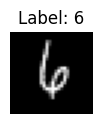

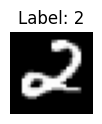

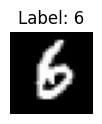

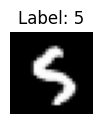

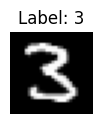

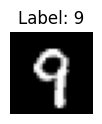

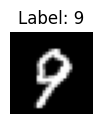

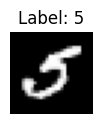

In [176]:
images, labels = next(iter(train_loader))  # Get the first batch of data (remember train_loaders are ITERABLE, and every iteration contains 1 mini-batch of data)

### Visualization Code Here
for i in range(8):
    plt.figure(figsize = (10, 10))
    plt.subplot(1, 8, i + 1)
    plt.imshow(images[i][0], cmap = 'gray')
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')
    plt.show()

#### Step 2: Creating a model [10 Marks]

In this step, we will define the architecture of a simple Feed-Forward Neural Network (FFNN) for MNIST classification. The network will have:
- An input layer corresponding to the size of the MNIST images. (Think about how to tackle dimensionality here)
- A few fully connected hidden layers with simple activation functions (e.g., ReLU).
- An output layer (Again think about the dimensionality here)
- Make sure that your total parameters do not exceed 600,000


We will use `torch.nn.Module` to define the model structure. You are free to choose any appropriate activation functions of your choice. You can look into the documentation [here](https://pytorch.org/docs/stable/nn.html), some useful functions that you should look up are:
```python
nn.Linear()
nn.Sequential()
nn.Sigmoid()
nn.ReLU()
```

In [177]:
class SimpleFFNN(nn.Module):
    def __init__(self):
        super(SimpleFFNN, self).__init__()

        self.input_layer = nn.Linear(28 * 28, 512)
        self.hidden_layers = nn.Sequential(
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
        )
        self.output_layer = nn.Linear(16, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.input_layer(x)
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x

In [178]:
# Instantiate the model
model = SimpleFFNN()
model.to(device)

# Print the number of parameters in the model
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

# Print the model structure
print(model)

577178
SimpleFFNN(
  (input_layer): Linear(in_features=784, out_features=512, bias=True)
  (hidden_layers): Sequential(
    (0): ReLU()
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=64, bias=True)
    (6): ReLU()
    (7): Linear(in_features=64, out_features=32, bias=True)
    (8): ReLU()
    (9): Linear(in_features=32, out_features=16, bias=True)
    (10): ReLU()
  )
  (output_layer): Linear(in_features=16, out_features=10, bias=True)
)


#### Step 3: Training your model [10 Marks]

Before we begin training, we will need to set up a loss function and an optimizer for training our model.

In this assignment, we will use `nn.CrossEntropyLoss` for classification. Like any loss function, CELoss would expect `y_true` and `y_predicted`. One thing I want you to think about is whether you should pass raw logits or softmax outputs as y_predicted, and why. (This may also have an implication on your model's forward pass). Make sure you look at the example in the documentation [here](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

The `optimizer` is a PyTorch class that updates the model's weights based on the gradients computed during backpropagation. For this assignment our optimizer will use simple Stochastic Gradient Descent, `SGD`, that you studied in class. You may look at the documentation [here](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html).


Useful functions that you should know are:
```python
loss.backward() # Does backpropagation after calculating the loss
optimizer.zero_grad() # clears old gradients before computing new ones to prevent accumulation
optimizer.step() # updates the weights based on the computed gradients.
```

In [179]:
# Define the loss function
loss_function = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)

We can finally begin training our network. You should be careful when handling gradients, loss computation, and weight updates through backpropagation.

Since we might have to train our model multiple times, it is good practice to write a training loop. The training loop should be a function that does the following:

1. Forward Pass: Pass the input data through the model to get predictions (logits).
2. Loss Calculation: Compute the loss by comparing the logits and the true labels.
3. Zero Gradients: Call `optimizer.zero_grad()` to reset the gradients from the previous iteration.
4. Backward Pass: Call `loss.backward()` to compute the gradients of the loss with respect to each model parameter. This step performs backpropagation.
5. Update Weights: Call `optimizer.step()` to update the model's weights based on the computed gradients.

Note that
- Backpropagation: `loss.backward()` computes the gradient of the loss for each parameter in the model. These gradients are used by the optimizer to update the model parameters.
- Ensure that gradients are reset at the start of each iteration using `optimizer.zero_grad()`, so they don't accumulate.
- Make sure you move both your model and inputs to device.
- It may be a good idea to print the loss after every few iterations, perhaps you may also look into `tqdm` [here](https://tqdm.github.io/).

In [180]:
def train_loop(model, train_loader, test_loader, optimizer, loss_function, device):
    model.train()
    total_loss = 0.0
    for batch_x, y_true in train_loader:
        batch_x, y_true = batch_x.to(device), y_true.to(device)
        optimizer.zero_grad()
        y_pred = model(batch_x)
        loss = loss_function(y_pred, y_true)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

It is also a useful to have a function to evaluate the model's performance on test data. We will use an `evaluate` function that takes the model and dataloader. Since we do not need any backpropagation during inference, you should wrap your function in `torch.no_grad()` to disable gradient computation, saving memory and computation. Your function should return both average accuracy and loss.

In [181]:
def evaluate(model, test_loader, device): # return loss and accuracy
    with torch.no_grad():
        total_loss = 0
        correct = 0
        total = 0
        for batch_x, y_true in test_loader:
            batch_x, y_true = batch_x.to(device), y_true.to(device)
            y_pred = model(batch_x)
            loss = loss_function(y_pred, y_true)
            total_loss += loss.item()
            _, predicted = torch.max(y_pred.data, 1)
            total += y_true.size(0)
            correct += (predicted == y_true).sum().item()
        accuracy = 100 * correct / total
        avg_loss = total_loss / len(test_loader)
    return avg_loss, accuracy

Understanding Training Terminology:

`Epoch`: One complete pass through the entire training dataset. Training over multiple epochs allows the model to learn progressively.

`Batch`: A small subset of the dataset used to compute the gradient and update the model. Mini-batches enable efficient computation and provide more frequent updates compared to processing the full dataset at once.

`Iteration`: One update of the model's parameters, which occurs after processing a single mini-batch. The total number of iterations per epoch is the number of training samples divided by the batch size.

You should now use your train loop to train your model upto a desired number of epochs. It may be a good idea to use your `val_loader` to evaluate the model after every epoch. This will allow you to see if the model generalizes well and potentially detect any overfitting. Make sure that you record your average train and validation loss for each epoch because you will have to plot them.

In [182]:
epochs = 5
train_losses = []
val_losses = []
# Train the model for a desired number of epochs.
for epoch in range(epochs):
    train_loss = train_loop(model, train_loader, test_loader, optimizer, loss_function, device)
    val_loss, val_accuracy = evaluate(model, val_loader, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

Now you should plot your loss curves (for both train and validation) for each epoch

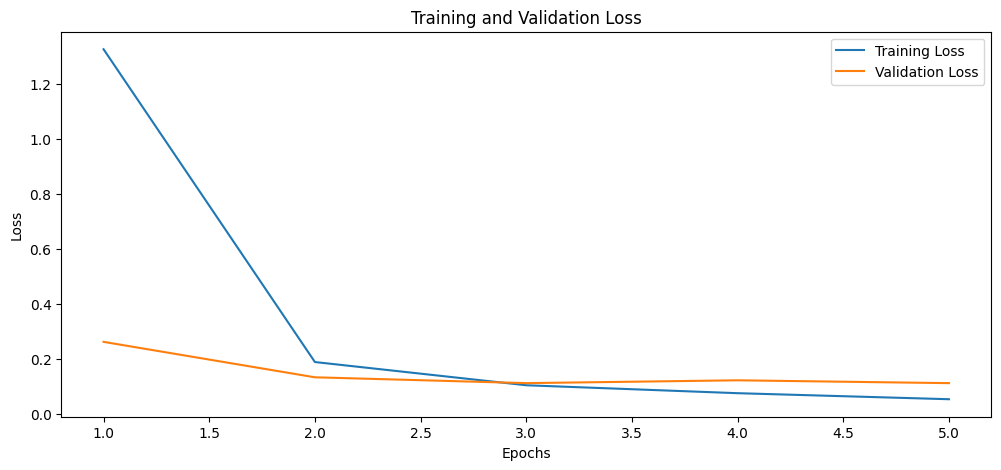

In [183]:
epochs_range = [1, 2, 3, 4, 5]
plt.figure(figsize=(12, 5))
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

Finally, we will use `test_loader` to evaluate our trained model. Remember that the accuracy here should be **atleast 95%**. If the desired accuracy is not reached, you should first check your implementation, and if its correct, then start tweaking the hyperparameters and retrain your model until you reach the desired accuracy.

In [184]:
## Evaluate the model.
test_loss, test_accuracy = evaluate(model, test_loader, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.1031, Test Accuracy: 97.30%


#### Step 4: Saving your model

In PyTorch, there are two main ways to save models: **state dictionary** and **full model saving**.

State Dictionary:
- The `state_dict` contains all the parameters of the model (weights and biases).
- Saving the state_dict allows you to only store the learned parameters, making the saved file smaller and more flexible. You can load it into any model architecture that matches the saved parameters.

Full Model Saving:
- Saving the full model stores both the model's architecture and its parameters. This method is more convenient as it preserves the entire model structure but results in larger file sizes.

Why Save Your Model?
Saving your model is crucial because once the kernel crashes or you close your laptop, you lose your model and its training progress. Saving the model ensures you can resume from where you left off, perform inference, or share your trained model with others.

Once you have saved your model, you can load it back into memory using `torch.load()`. This allows you to restore the model's architecture and learned parameters, enabling you to run inference or continue training from where you left off.

For this assignment, we will save the full model, as it will be used for inference and grading. Use `torch.save()` to save the model. This will allow us to run inference on the saved model during evaluation and grading.

In [185]:
# Save the entire model
torch.save(model, 'G_69_S_1_FNN.pth')

## Section 3: Convolutional Neural Networks [30 Marks]

### Step 1: Loading & Visualizing CIFAR-10

You now understand the flow of training a model. Let's now train a Convolutional Neural Network using our knowledge from Part 2. Like always, the first step is to load CIFAR-10 and Construct Dataloaders.

- Use torchvision.datasets.CIFAR10 to download the dataset.
- Apply transformations: convert images to tensors and normalize them using mean [0.4914, 0.4822, 0.4465] and std [0.2470, 0.2435, 0.2616] for each RGB channel.
- Split the dataset into training (80%), validation (10%), and test (10%) sets.
- Create DataLoader instances with a reasonable batch size (32 or 64), make sure you shuffle the training data.
- Visualize atleast 10 samples from the training set including their labels (label and not label index).

In [186]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])  # Define transforms (ToTensor + Normalize)

dataset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = transform)    # Download CIFAR-10 with transforms
train_set, validation_set = torch.utils.data.dataset.random_split(dataset, [40000, 10000])  # Split into training and validation sets
test_set = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transform)  # Download CIFAR-10 test set
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 64, shuffle = True)  # DataLoader for training
val_loader = torch.utils.data.DataLoader(validation_set, batch_size = 64, shuffle = False)     # DataLoader for validation
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 64, shuffle = False)   # DataLoader for 

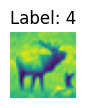

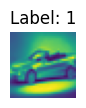

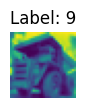

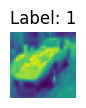

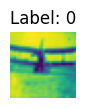

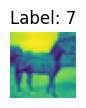

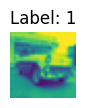

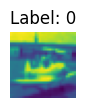

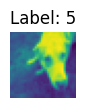

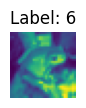

In [187]:
### Visualize 10 Samples
images, labels = next(iter(train_loader))  # Get the first batch of data (remember train_loaders are ITERABLE, and every iteration contains 1 mini-batch of data)

### Visualization Code Here
for i in range(10):
    plt.figure(figsize = (10, 10))
    plt.subplot(1, 10, i + 1)
    plt.imshow(images[i][0])
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')
    plt.show()


### Step 2: Model Architecture

Design a Simple CNN model. Ensure the model handles 3-channel input (RGB) and outputs 10 classes. Make sure that total parameters must be less than `5 million`.

You may find the following modules useful:

```python
nn.Conv2d
nn.MaxPool2d
nn.Dropout
nn.Linear
nn.ReLU
nn.Sigmoid
nn.BatchNorm2d
```

In [188]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),

            nn.Flatten(),

            nn.Linear(512 * 2 * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 128),
            nn.ReLU(),

            nn.Linear(128, 10)

        )
    
    def forward(self, x):
        return self.layer(x)

Instantiate your model and print the number of parameters

In [189]:
model = SimpleCNN()
model.to(device)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(num_params)

2668938


### Step 3: Train your model

Reuse the `train_loop` and `evaluate` functions from Part 2. Declare an appropriate loss function and optimizer. Adjust hyperparameters (e.g., learning rate) as needed. You should train your model for no more than `10 epochs`. Make sure you plot your loss curves (train and validation) for every epoch.

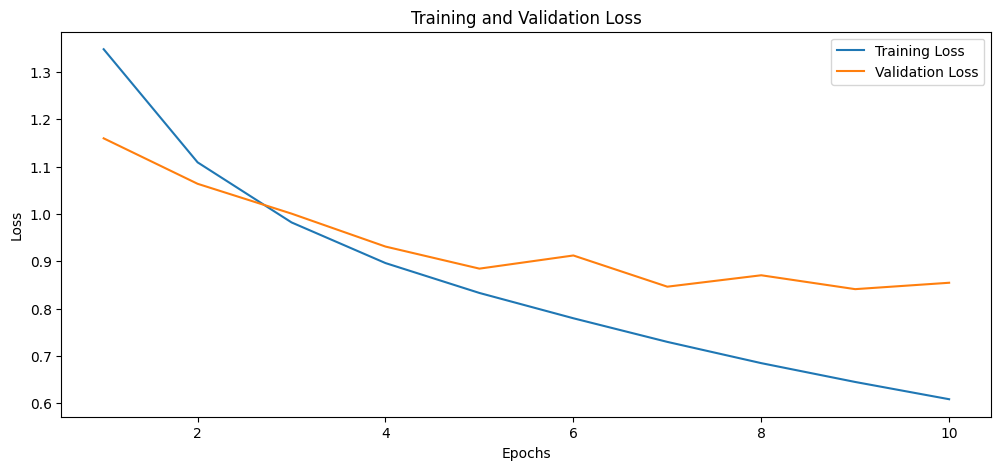

In [192]:
loss_function = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)


epochs = 10
train_losses = []
val_losses = []
# Train the model for a desired number of epochs.
for epoch in range(epochs):
    train_loss = train_loop(model, train_loader, test_loader, optimizer, loss_function, device)
    val_loss, val_accuracy = evaluate(model, val_loader, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

epochs_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.figure(figsize=(12, 5))
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

### Step 4: Evaluate your model

You should evaluate your model on the test dataloader now. Make sure that your test accuracy is atleast `70%`. If it is less then unfortunately you will have to tweak your hyperparameters or model architectures and retrain (or lose some marks?).

In [193]:
## Evaluate the model.
test_loss, test_accuracy = evaluate(model, test_loader, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.8689, Test Accuracy: 78.06%


### Step 5: Save your model


Save your final model as a `.pth` file. Make sure you save the entire model and not just the state dictionary. We will load your model and test it, so make sure you save your best model.

In [194]:
# Save the entire model
torch.save(model, 'G_69_S_1_CNN.pth')

## Section 4: Exploration [30 Marks]

You are to attempt any 2 tasks out of the 3.

### Task 1: Transfer Learning

Transfer learning is the process of adapting a pre-trained model to a new, related task by fine-tuning its parameters, thereby leveraging the general features learned from large datasets such as ImageNet. Pretrained models, also known as foundation models, capture a diverse range of features that are useful for many vision tasks, and fine-tuning these models requires less computational resources and data compared to training a network from scratch.

This task will help you understand the process of working with pretrained models in PyTorch, focusing on importing the VGG11 model pretrained on ImageNet, freezing its backbone, and fine-tuning a new classifier head for CIFAR10.

Follow the steps below to understand the workflow.

You should do the following steps:
- You should import a pretrained [VGG11]((https://pytorch.org/vision/main/models/generated/torchvision.models.vgg11.html).) model from torchvision.
- By importing `VGG11_Weights` and then using the `ImageNet22k_Weights.DEFAULT` option within the model loading function, the VGG11 model will be initialized with weights obtained from extensive training on approximately 14 million images across 22,000 classes.
- To adapt the pretrained VGG11 model for CIFAR10, which has 10 classes, a common strategy is to freeze the backbone and train a new classifier head.
- The Backbone refers to the convolutional base of the VGG11 model responsible for feature extraction.
- Freezing involves setting the parameters of the backbone layers so that their values do not change during training (for example, by setting `requires_grad=False` on these parameters).
- This approach leverages the already learned features from ImageNet, reducing the training time and required amount of CIFAR10 data.
- After freezing the backbone, the final classification layer (or head) is replaced or modified to suit the CIFAR10 classification task.
- The new classifier head is initialized with random weights and is trained on CIFAR10 data.
- Only the parameters of this new head are updated during training, which helps in adapting the model’s predictions to the specifics of CIFAR10.
- Finally, you should evaluate the accuracy of your pretrained model on CIFAR-10 and compare it with when you trained the model from scratch in the previous part. Also comment briefly on the training time/compute required for both of the tasks.

In [ ]:
# Importing VGG11 and freezing its backbone (all from documentation), and training new head/dataset for CIFAR10

from torchvision.models import vgg11, VGG11_Weights
import torchvision.transforms as transforms


model = torchvision.models.vgg11(weights=VGG11_Weights.IMAGENET1K_V1)

# Freezing classifier and training new classifier head
for param in model.features.parameters():
    param.requires_grad = False

# Training new head because VGG has 1000 output classes but CIFAR10 has only 10
model.classifier[6] = nn.Linear(4096, 10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

# Training CIFAR10 images on VGG model
# First specify ke jo data import kerain ga us mein kiya kiya changes kerni, resize kerna, normalize kerna and then tensor bhi banana.
# After this, just download the dataset and pass it through this pipeline/workflow

transform = transforms.Compose([transforms.Resize(224),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train_set = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)

# Abh train_set ka batches banana hain aur unhain data loaders ke through model se train kerna hai
train_loader = torch.utils.data.DataLoader(train_set,batch_size=64,shuffle=True)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        for i in range(len(predicted)):
          if predicted[i] == labels[i]:
              correct += 1
          else:
              correct += 0

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')


Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:07<00:00, 73.7MB/s]
100%|██████████| 170M/170M [00:03<00:00, 43.1MB/s]


Epoch [1/10], Loss: 0.7271, Accuracy: 76.69%
Epoch [2/10], Loss: 0.5183, Accuracy: 84.59%
Epoch [3/10], Loss: 0.4103, Accuracy: 88.22%
Epoch [4/10], Loss: 0.3730, Accuracy: 89.90%
Epoch [5/10], Loss: 0.3458, Accuracy: 90.84%
Epoch [6/10], Loss: 0.3185, Accuracy: 92.11%
Epoch [7/10], Loss: 0.2942, Accuracy: 93.08%
Epoch [8/10], Loss: 0.2725, Accuracy: 93.44%
Epoch [9/10], Loss: 0.2596, Accuracy: 93.96%
Epoch [10/10], Loss: 0.2554, Accuracy: 94.24%


The accuraccy increases with each epoch i.e each time a model is trained. Originaly VGG11 is a model that has been trained to classify ImageNet dataset but by the virtue of transfer learning we just changed the last layer such that the modified VGG11 was able to classify the data into 10 classes.

 During training, the model quickly improves, with accuracy rising from 76.69% to 94.24% over just 10 epochs, and loss steadily decreasing hence showing effective learning. I think that the accuraccy would further increase if we increase the number of epochs.

### Task 2: GradCAM Visualizations

GradCAM (Gradient-weighted Class Activation Mapping) provides visual explanations for CNN decisions by highlighting important regions in an image. This guide walks through setting up GradCAM with a pretrained model, visualizing feature maps, and additional tips for interpretability.

GradCAM reveals where a CNN looks to decide on a class. By computing the gradient of the output with respect to a convolutional layer's features and applying a ReLU on the weighted sum, a heatmap is produced. Overlaying this heatmap on the original image shows the regions influencing the model's decision. You need to refer to the [official repository](https://github.com/jacobgil/pytorch-grad-cam) here to see usage examples.

To conduct a gradcam analysis, you need the following:
- Your CNN Model from Part 3
- Select a target layer.
- Select a target class. For example, `ClassifierOutputTarget(0)` would visualize for class 0.
- Generate and Visualize the Heatmap.

Your task is to preprocess 6 input images from different classes, generate the GradCAM heatmap, and overlay it on the original image. You are to submit these visualizations.

In [ ]:
### You are free to make as many cells as you want

### Task 3: Out of Distribution (OOD) Robustness

Machine learning models often perform remarkably well on test data drawn from the same distribution as their training data. However, they can fail drastically when faced with Out-of-Distribution (OOD) inputs—data that deviates from what the model has seen during training.

Imagine a model trained to classify images of animals. It may correctly identify a photo of a horse but struggle with a sketch of a horse, even though both are semantically the same. This is a classic case of OOD generalization failure. Similarly, a model trained only on images taken during the day may perform poorly on images captured at night, even though the underlying objects remain the same.

In this task, you will investigate how robust your models are when faced with such distributional shifts by conducting a simple experiment. Your MNIST classifier has likely never seen digits written by you. In this task, you will generate OOD data by manually writing digits on paper, photographing them, and testing the model’s predictions.

Steps:
- Write digits 0–9 on a blank sheet of paper.
- Take clear, well-lit photos of the sheet.
- Load and Visualize these JPEGs
- We now preprocess each image. Convert it to grayscale tensors.
- Invert the colors (so the digits are white on a black background).
- Resize it to 28x28 pixels using transforms.Resize
- Perform any other transforms that you did on your original MNIST dataset such as normalization.
- Pass these images through your trained MNIST model and observe how it performs.
- Comment on your accuracy and on which digits were easier or harder to classify and hypothesize why.

By conducting these experiments, you'll gain a better understanding of how fragile deep learning models can be when moved away from their original training distribution—and why OOD robustness is an important topic in real-world deployments.

In [35]:
from PIL import Image,ImageOps

# making transform pipeline
ood_transform = torchvision.transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=1),torchvision.transforms.Resize((28, 28)),torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.1307,), (0.3081,))])


# Importing the images and storing them in an array
image_dir = "/content/"
image_paths = []

for i in range(10):
  image_paths.append(f"{image_dir}{i}.jpg")

# Images ka tensor bana ker batch size dimension daalo
tensor_images = []
true_labels = []
for img_path in image_paths:
    # Extract and store true_label
    true_label = int(img_path.split('/')[-1].split('.')[0])
    true_labels.append(true_label)

    img = Image.open(img_path)
    img = ImageOps.invert(img.convert('L'))
    img_tensor = ood_transform(img).unsqueeze(0).to(device) #kion ka model expects batch to add a batch size of 1 (1,28,28) ->(1,1,28,28)
    tensor_images.append(img_tensor)

# Concatenate the images, change dimention 0 of batch size from 1 to 10 bec 10 images
tensor_images = torch.cat(tensor_images, dim=0)


model.eval()

predictions = []
for img_tensor in tensor_images:
  # Disable gradient ki calculations because we have weights pehle
    with torch.no_grad():
        output = model(img_tensor.unsqueeze(0))
        # Extract the value with most prediction and store it in predictions array
        prediction = output.argmax(dim=1).item()
        predictions.append(prediction)


# Evaluating:
correct_predictions = 0
for i in range(len(true_labels)):
    true_label = true_labels[i]
    predicted_label = predictions[i]

    print(f"Image {i+1}: True label = {i}, Predicted label = {predicted_label}")
    if true_label == predicted_label:
        correct_predictions += 1

accuracy = (correct_predictions / len(true_labels)) * 100
print(f"Accuracy: {accuracy:.2f}%")

Image 1: True label = 0, Predicted label = 9
Image 2: True label = 1, Predicted label = 1
Image 3: True label = 2, Predicted label = 5
Image 4: True label = 3, Predicted label = 5
Image 5: True label = 4, Predicted label = 4
Image 6: True label = 5, Predicted label = 5
Image 7: True label = 6, Predicted label = 6
Image 8: True label = 7, Predicted label = 4
Image 9: True label = 8, Predicted label = 8
Image 10: True label = 9, Predicted label = 5
Accuracy: 50.00%
